# Code for `TensorFlow`/`Keras`


##### Algo:

1. Ingest data
2. Plot data
3. Visually inspect data
4. Use Isolation Forest to isolate Anomaly
5. Remove Anomaly from dataset
6. Re-plot data
7. Keep using steps 4-6 until all data in y-series falls within ~XYZ% range of acceptance

In [6]:
###### import all needed modules

#import keras
import numpy as np
from matplotlib import pyplot
import pandas as pd
from pandas import DataFrame
import sklearn
from sklearn.ensemble import IsolationForest
from datetime import datetime

### Read files in
FILE_1k = './anomaly-1k.csv'
FILE_5k = './anomaly-5k.csv'
FILE_ALL = './Anomaly_Data_NO-CR.csv'

def ingest_csv(FILE):
    # Dateformat: 01-Mar-17 (%d-%b-%y)
    #dateparse = lambda x: pd.to_datetime(pd.datetime.strptime(x, '%d-%b-%y'))
    dateparse = lambda x: float( (pd.to_datetime(pd.datetime.strptime(x, '%d-%b-%y')) - datetime(1970, 1, 1)).total_seconds() )

    # nrows=10000
    return pd.read_csv(FILE, sep=',', parse_dates=['TRANSACTION_DATE'], date_parser=dateparse)

### Initialize dataframes
df_1k = ingest_csv(FILE_1k)
df_5k = ingest_csv(FILE_5k)
#df_all = ingest_csv(FILE_ALL)

#df = df_1k

In [11]:
#group_tdate = df['DC_PROD_NAME'].groupby(by="TRANSACTION_DATE")#, axis='columns')
group_tdate = df['DC_PROD_NAME'].groupby(by=[df['ACCOUNT_NAME']])
x = list(group_tdate.indices.keys())
y = list(group_tdate.count())
#print(i[0] for i in x)
xx = []
for i in x:
    xx.append(i[0])
#print(xx)
#print(y)
pyplot.scatter(xx,y)

NameError: name 'df' is not defined

In [7]:
### Get the sets we will use to train/predict
def get_costdiff_sets(dframe):
    g_cd = (dframe['DELIVERED_PRICE']-(dframe['UNIT_PRICE'] * dframe['DELIVERED_QUANTITY'])).groupby(dframe['TRANSACTION_DATE'])
    cd_x = list(g_cd.indices.keys()) # Product IDs
    cd_y = list(g_cd.mean()) # Average differences
    return (cd_x, cd_y)

### The x/y training sets for Isolation forests
def gen_set(x, y):
    xx = []
    yy = []
    e=0
    for i in range(len(x)):
        try:
            xx.append(float(x[i]))
            yy.append(y[i])
        except:
            e+=1
    return (xx, yy, e)

([Timestamp('1970-01-01 00:00:01.488326400'), Timestamp('1970-01-01 00:00:01.488499200'), Timestamp('1970-01-01 00:00:01.488758400'), Timestamp('1970-01-01 00:00:01.488931200'), Timestamp('1970-01-01 00:00:01.489104'), Timestamp('1970-01-01 00:00:01.489363200'), Timestamp('1970-01-01 00:00:01.489536'), Timestamp('1970-01-01 00:00:01.489622400'), Timestamp('1970-01-01 00:00:01.489708800'), Timestamp('1970-01-01 00:00:01.489968'), Timestamp('1970-01-01 00:00:01.490140800'), Timestamp('1970-01-01 00:00:01.490313600'), Timestamp('1970-01-01 00:00:01.490572800'), Timestamp('1970-01-01 00:00:01.490745600'), Timestamp('1970-01-01 00:00:01.490918400'), Timestamp('1970-01-01 00:00:01.491177600'), Timestamp('1970-01-01 00:00:01.491264'), Timestamp('1970-01-01 00:00:01.491350400'), Timestamp('1970-01-01 00:00:01.491523200'), Timestamp('1970-01-01 00:00:01.491782400'), Timestamp('1970-01-01 00:00:01.491955200'), Timestamp('1970-01-01 00:00:01.492128'), Timestamp('1970-01-01 00:00:01.492387200'), T

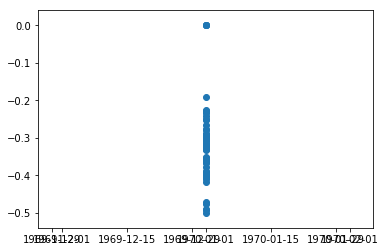

In [8]:
### Get our set that we are using to compare
costdiff_1k = get_costdiff_sets(df_1k)
print(costdiff_1k)

### The sets we will use to train
costdiff_1k_x = costdiff_1k[0]
costdiff_1k_y = costdiff_1k[1]

pyplot.scatter(costdiff_1k_x, costdiff_1k_y)

In [5]:
rng = np.random.RandomState()
clf = IsolationForest(behaviour='new', max_samples=len(costdiff_1k_x), random_state=rng, contamination='auto')

def link_sets(x, y):
    xy = []
    for i in range(len(x)):
        xy.append([x[i],y[i]])
    return xy
cd1kxy = link_sets(costdiff_1k_x,costdiff_1k_y)
clf.fit(cd1kxy)

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
costdiff_5k = get_costdiff_sets(df_5k)
costdiff_5k_x = costdiff_5k[0]
costdiff_5k_y = costdiff_5k[1]
cd5kx,cd5ky,e5k = gen_set(costdiff_5k_x, costdiff_5k_y)
cd5kxy = link_sets(cd5kx, cd5ky)
clf.predict(cd5kxy)

pyplot.scatter(costdiff_5k_x, costdiff_5k_y)

In [ ]:
costdiff_all = get_costdiff_sets(df_all)
costdiff_all_x = costdiff_all[0]
costdiff_all_y = costdiff_all[1]
cdAx,cdAy,eAk = gen_set(costdiff_all_x, costdiff_all_y)
cdAxy = link_sets(cdAx, cdAy)
print(eAk)
clf.predict(cdAxy)

pyplot.scatter(cdAx, cdAy)

In [ ]:
import matplotlib.pyplot as plt

xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(cd1kxy[:][0], cd1kxy[:][1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(cd5kxy[:][0], cd5kxy[:][1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(cdAxy[:][0], cdAxy[:][1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()